<a href="https://colab.research.google.com/github/Donorone35/IMdb_Sentiment-_Analyzer/blob/main/IMdb_Sentiment__Analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Dependency


In [2]:
import os
import json
import pandas as pd

from zipfile import ZipFile
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Data Collection through Kaggle API


In [3]:
with open('kaggle.json') as f:
    kaggle_dict = json.load(f)
os.environ['KAGGLE_USERNAME'] = kaggle_dict['username']
os.environ['KAGGLE_KEY'] = kaggle_dict['key']
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
  0% 0.00/25.7M [00:00<?, ?B/s]
100% 25.7M/25.7M [00:00<00:00, 1.24GB/s]


In [4]:
with ZipFile('imdb-dataset-of-50k-movie-reviews.zip', 'r') as zip_ref:
    zip_ref.extractall()

data =  pd.read_csv("/content/IMDB Dataset.csv")
data.shape
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
data['sentiment'].value_counts()

,count
sentiment,
positive,25000
negative,25000


In [6]:
data.replace({'sentiment': {'positive': 1, 'negative': 0}}, inplace=True)
print(data.head())

                                              review  sentiment
0  One of the other reviewers has mentioned that ...          1
1  A wonderful little production. <br /><br />The...          1
2  I thought this was a wonderful way to spend ti...          1
3  Basically there's a family where a little boy ...          0
4  Petter Mattei's "Love in the Time of Money" is...          1


<ipython-input-6-3493438924>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({'sentiment': {'positive': 1, 'negative': 0}}, inplace=True)


 Data Spliting and Preprocessing

In [7]:
# Split Data Into Train and Test Sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Initialize and Fit Tokenizer on Train Reviews
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data['review'])

# Convert Text to Sequences and Pad
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data['review']), maxlen=200, padding='post', truncating='post')
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data['review']), maxlen=200, padding='post', truncating='post')

# Labels
Y_train = train_data['sentiment'].values
Y_test = test_data['sentiment'].values

print("X_train:", X_train)
print("X_test:", X_test)
print("Y_train:", Y_train)
print("Y_test:", Y_test)

X_train: [[ 198   49   11 ... 3750 1829    3]
 [  11  117   22 ...    1    1  189]
 [   4 1336  114 ...    0    0    0]
 ...
 [ 794   12   28 ...    0    0    0]
 [  12  353   14 ...    0    0    0]
 [  12    7    4 ...    0    0    0]]
X_test: [[  11   64  424 ...  382  270  189]
 [  22  108  704 ...  266    5  451]
 [   2   20  921 ...    0    0    0]
 ...
 [ 432  696    1 ...  105  123 1049]
 [  15  226   15 ...    0    0    0]
 [  11  213 8344 ...    0    0    0]]
Y_train: [0 0 1 ... 0 1 1]
Y_test: [1 1 0 ... 1 0 1]


Model Training

In [9]:
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Define the model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=200))
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(1))

import tensorflow as tf
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [10]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, Y_train,
    batch_size=128,
    epochs=10,
    validation_data=(X_test, Y_test),
    callbacks=[early_stop]
)

# Final evaluation
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 427s 1s/step - accuracy: 0.5971 - loss: 0.6783 - val_accuracy: 0.8278 - val_loss: 0.4201
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 431s 1s/step - accuracy: 0.8245 - loss: 0.4161 - val_accuracy: 0.7754 - val_loss: 0.4535
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step - accuracy: 0.8460 - loss: 0.3686 - val_accuracy: 0.8535 - val_loss: 0.3689
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 440s 1s/step - accuracy: 0.8760 - loss: 0.3170 - val_accuracy: 0.8659 - val_loss: 0.3453
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 449s 1s/step - accuracy: 0.8916 - loss: 0.2792 - val_accuracy: 0.8642 - val_loss: 0.3496
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 438s 1s/step - accuracy: 0.9039 - loss: 0.2596 - val_accuracy: 0.8507 - val_loss: 0.3703
313/313 ━━━━━━━━━━━━━━━━━━━━ 69s 221ms/step - accuracy: 0.8682 - loss: 0.3450
Test Loss: 0.3453
Test Accuracy: 0.8659


Building a Predictive System

In [11]:
import re
import tensorflow as tf

def predict_sentiment(review):
    review = review.lower().strip()
    review = re.sub(r'[^a-zA-Z0-9\s]', '', review)

    sequence = tokenizer.texts_to_sequences([review])
    padded = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=200)

    logit = model.predict(padded, verbose=0)
    prob = tf.sigmoid(logit).numpy()[0][0]
    sentiment = "positive" if prob > 0.5 else "negative"

    return sentiment

In [12]:
new_review = "The Movie was Great. I loved it!"
predicted_sentiment = predict_sentiment(new_review)
print(f"Predicted Sentiment: {predicted_sentiment}")

Predicted Sentiment: positive


In [13]:
new_review = "It was a total waste of time. Horrible acting!"
predicted_sentiment = predict_sentiment(new_review)
print(f"Predicted Sentiment: {predicted_sentiment}")

Predicted Sentiment: negative


In [14]:
new_review = "Mediocre script but great visuals."
predicted_sentiment = predict_sentiment(new_review)
print(f"Predicted Sentiment: {predicted_sentiment}")

Predicted Sentiment: positive


In [15]:
new_review = "the movie was good but ending was bad "
predicted_sentiment = predict_sentiment(new_review)
print(f"Predicted Sentiment: {predicted_sentiment}")

Predicted Sentiment: negative


Plot of Training/Validation Accuracy and Loss

313/313 ━━━━━━━━━━━━━━━━━━━━ 72s 226ms/step


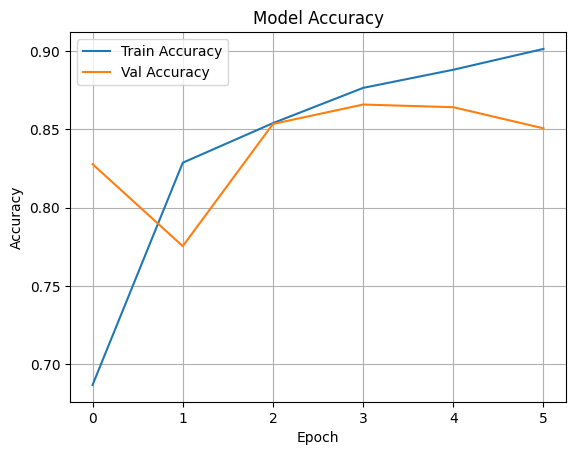

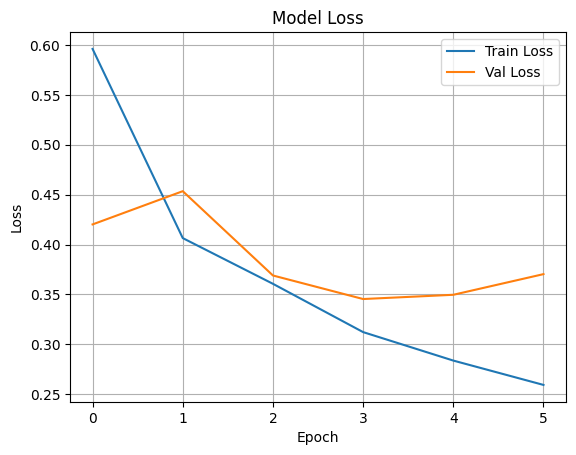

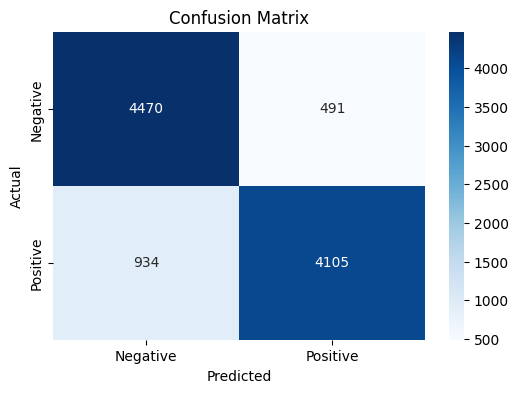

In [17]:
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.savefig("accuracy_plot.png")

# Loss plot
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.savefig("loss_plot.png")

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict class labels
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Classification report
print(classification_report(Y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(Y_test, y_pred)

# Plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [21]:
from google.colab import files

files.download("accuracy_plot.png")
files.download("loss_plot.png")
files.download("confusion_matrix.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>